In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

In [2]:
scenarios = [
    "alibaba",
    "nyctaxi",
]
solar_sites = [
    "berlin",
    "cdmx",
    "capet",
]
policies = [
    "Baseline 1",  # Perfect forecasts for spare capacity
    "Baseline 2",  # Perfect forecasts for green excess capacity
    "Naive",  # Perfect forecasts for green excess capacity
    "Conservative",  # Real forecasts for green capacity (conservative)
    "Expected",  # Real forecasts for green capacity
    "Optimistic",  # Real forecasts for green capacity (optimistic)
]

In [3]:
jobs = []
for scenario in scenarios:
    for solar_site in solar_sites:
        for policy in policies:
            with open(f"results/jobs_{scenario}_{solar_site}_{policy}.csv", "r") as csvfile:
                df = pd.read_csv(csvfile, parse_dates=True)
            df["scenario"] = scenario
            df["solar_site"] = solar_site
            df["policy"] = policy
            jobs.append(df)
jobs = pd.concat(jobs)
jobs.head(5)

,id,status,mch,arrive time,finish time,deadline,scenario,solar_site,policy
0,0,SUCCESS,50.0,2022-01-18 00:09:45,2022-01-18 00:09:46,2022-01-19,alibaba,berlin,Baseline 1
1,1,SUCCESS,50.0,2022-01-18 00:10:17,2022-01-18 00:11:05,2022-01-19,alibaba,berlin,Baseline 1
2,2,SUCCESS,50.0,2022-01-18 00:30:26,2022-01-18 00:31:06,2022-01-19,alibaba,berlin,Baseline 1
3,3,SUCCESS,50.0,2022-01-18 00:38:51,2022-01-18 00:38:56,2022-01-19,alibaba,berlin,Baseline 1
4,4,SUCCESS,50.0,2022-01-18 01:17:59,2022-01-18 01:18:09,2022-01-19,alibaba,berlin,Baseline 1


In [4]:
x = jobs[["scenario", "solar_site", "policy", "status"]].copy()
x["rejected"] = jobs["status"] == "REJECTED"
x["success"] = jobs["status"] == "SUCCESS"
x["miss"] = jobs["status"] == "MISS"
x = x.groupby(["scenario", "solar_site", "policy"]).sum()
x["total"] = x.sum(axis=1)
x["accepted"] = x["success"] + x["miss"]
x = x[["total", "accepted", "rejected", "success", "miss"]]
x

total  accepted  rejected  success  miss
scenario solar_site policy                                                
alibaba  berlin     Baseline 1     5477      5477         0     5477     0
                    Baseline 2     5477       112      5365      112     0
                    Conservative   5477       112      5365      112     0
                    Expected       5477       329      5148      329     0
                    Naive          5477       123      5354      123     0
                    Optimistic     5477      1071      4406     1071     0
         capet      Baseline 1     5477      5477         0     5477     0
                    Baseline 2     5477      2442      3035     2442     0
                    Conservative   5477      2405      3072     2405     0
                    Expected       5477      2507      2970     2507     0
                    Naive          5477      1882      3595     1882     0
                    Optimistic     5477      2660      2817     2660     0
         cdmx       Baseline 1     5477      5477         0     5477     0
                    Baseline 2     5477      2051      3426     2051     0
                    Conservative   5477      1774      3703     1774     0
                    Expected       5477      2194      3283     2194     0
                    Naive          5477      1591      3886     1591     0
                    Optimistic     5477      2354      3123     2354     0
nyctaxi  berlin     Baseline 1     2983      2967        16     2967     0
                    Baseline 2     2983        12      2971       12     0
                    Conservative   2983         4      2979        4     0
                    Expected       2983        31      2952       31     0
                    Naive          2983        36      2947       35     1
                    Optimistic     2983       270      2713      266     4
         capet      Baseline 1     2983      2967        16     2967     0
                    Baseline 2     2983      1055      1928     1055     0
                    Conservative   2983       957      2026      957     0
                    Expected       2983      1060      1923     1060     0
                    Naive          2983       989      1994      988     1
                    Optimistic     2983      1140      1843     1133     7
         cdmx       Baseline 1     2983      2967        16     2967     0
                    Baseline 2     2983       866      2117      866     0
                    Conservative   2983       568      2415      568     0
                    Expected       2983       889      2094      889     0
                    Naive          2983       827      2156      826     1
                    Optimistic     2983      1042      1941     1041     1

# Power Usage

In [5]:
def experiment_power_df(scenario, solar_site):
    with open(f"results/u_{scenario}_{solar_site}_Expected.csv", "r") as csvfile:
        base_df = pd.read_csv(csvfile, parse_dates=True, index_col=0).dropna()
    base_df = base_df.drop(columns=["u_freep", "u_free", "u_used"])

    dfs = []
    for experiment in policies:
        with open(f"results/u_{scenario}_{solar_site}_{experiment}.csv", "r") as csvfile:
            df = pd.read_csv(csvfile, parse_dates=True, index_col=0).dropna()
        df = df["u_used"].rename(experiment)
        dfs.append(df)
    return pd.concat([base_df] + dfs, axis=1)


df = experiment_power_df(scenario="nyctaxi", solar_site="cdmx")
df["2022-01-18 10:00:00":"2022-01-18 10:30:00"]

,u_reep,Baseline 1,Baseline 2,Naive,Conservative,Expected,Optimistic
datetime,,,,,,,
2022-01-18 10:00:00,147.852852,200.0,147.852852,147.852852,147.852852,147.852852,147.852852
2022-01-18 10:10:00,159.160611,300.0,159.160611,159.160611,159.160611,159.160611,159.160611
2022-01-18 10:20:00,170.687791,0.0,170.687791,92.986537,170.687791,170.687791,170.687791
2022-01-18 10:30:00,177.715769,200.0,177.715769,177.715769,177.715769,177.715769,177.715769


In [6]:
def total_and_brown_df(scenario, solar_site):
    df = experiment_power_df(scenario=scenario, solar_site=solar_site)
    u_reep = df["u_reep"]
    
    total_df = df.drop(columns=["u_reep"])
    total = (total_df.sum() / 6).rename("used_energy").to_frame()
    
    diff_df = total_df.subtract(u_reep, axis=0)
    brown_df = diff_df[diff_df > 0]
    brown = (brown_df.sum() / 6).rename("used_grid_energy").to_frame()
    
    total_and_brown = pd.concat([total, brown], axis=1)
    total_and_brown["scenario"] = scenario
    total_and_brown["solar_site"] = solar_site
    total_and_brown.index.name = "policy"
    total_and_brown = total_and_brown.reset_index()
    total_and_brown = total_and_brown.set_index(["scenario", "solar_site", "policy"])
    return total_and_brown

def get_energy_usage():
    dfs = []
    for scenario in scenarios:
        for solar_site in solar_sites:
            dfs.append(total_and_brown_df(scenario=scenario, solar_site=solar_site))
    return pd.concat(dfs)

energy_usage = get_energy_usage()
energy_usage

used_energy  used_grid_energy
scenario solar_site policy                                      
alibaba  berlin     Baseline 1    46008.333333      45100.901204
                    Baseline 2      941.666667          0.000000
                    Naive          1025.000000         99.429037
                    Conservative    941.666667        305.887106
                    Expected       2766.666667       1803.463818
                    Optimistic     9041.666667       8075.309423
         cdmx       Baseline 1    46008.333333      32552.481360
                    Baseline 2    17250.000000          0.000000
                    Naive         13383.333333        179.740964
                    Conservative  14958.333333         74.950539
                    Expected      18458.333333       1219.986416
                    Optimistic    19791.666667       2488.893685
         capet      Baseline 1    46008.333333      29983.055009
                    Baseline 2    20525.000000          0.000000
                    Naive         15825.000000        190.728842
                    Conservative  20233.333333          5.427136
                    Expected      21075.000000        523.194630
                    Optimistic    22358.333333       1791.105111
nyctaxi  berlin     Baseline 1    49450.000000      49189.298928
                    Baseline 2      200.000000          0.000000
                    Naive           600.000000        339.298928
                    Conservative     66.666667          0.000000
                    Expected        516.666667        280.591332
                    Optimistic     4500.000000       4244.697607
         cdmx       Baseline 1    49450.000000      36461.041964
                    Baseline 2    14433.333333          0.000000
                    Naive         13783.333333        625.772589
                    Conservative   9466.666667          0.000000
                    Expected      14816.666667        324.151240
                    Optimistic    17366.666667       2783.047669
         capet      Baseline 1    49450.000000      33538.034039
                    Baseline 2    17583.333333         11.725115
                    Naive         16483.333333        588.507249
                    Conservative  15950.000000          0.000000
                    Expected      17666.666667        110.855112
                    Optimistic    19000.000000       1378.960184

In [7]:
grid_frac = (energy_usage["used_grid_energy"] / energy_usage["used_energy"] * 100).rename("grid_frac")
acceptance_rate = (100 * x["accepted"] / x["total"]).rename("acceptance_rate")
overview = pd.concat([acceptance_rate, grid_frac], axis=1)
overview = overview.reindex(policies, level=2)  # Sort policy level
overview

acceptance_rate  grid_frac
scenario solar_site policy                                  
alibaba  berlin     Baseline 1         100.000000  98.027679
                    Baseline 2           2.044915   0.000000
                    Naive                2.245755   9.700394
                    Conservative         2.044915  32.483587
                    Expected             6.006938  65.185439
                    Optimistic          19.554501  89.312178
         capet      Baseline 1         100.000000  65.168748
                    Baseline 2          44.586452   0.000000
                    Naive               34.361877   1.205238
                    Conservative        43.910900   0.026823
                    Expected            45.773234   2.482537
                    Optimistic          48.566734   8.010906
         cdmx       Baseline 1         100.000000  70.753446
                    Baseline 2          37.447508   0.000000
                    Naive               29.048749   1.343021
                    Conservative        32.389995   0.501062
                    Expected            40.058426   6.609407
                    Optimistic          42.979733  12.575463
nyctaxi  berlin     Baseline 1          99.463627  99.472799
                    Baseline 2           0.402280   0.000000
                    Naive                1.206839  56.549821
                    Conservative         0.134093   0.000000
                    Expected             1.039222  54.308000
                    Optimistic           9.051291  94.326613
         capet      Baseline 1          99.463627  67.822111
                    Baseline 2          35.367080   0.066683
                    Naive               33.154542   3.570317
                    Conservative        32.081797   0.000000
                    Expected            35.534697   0.627482
                    Optimistic          38.216561   7.257685
         cdmx       Baseline 1          99.463627  73.733149
                    Baseline 2          29.031177   0.000000
                    Naive               27.723768   4.540067
                    Conservative        19.041234   0.000000
                    Expected            29.802213   2.187747
                    Optimistic          34.931277  16.025226

In [8]:
for policy in policies:
    agg = (
        overview.loc["alibaba", "capet", policy] + 
        overview.loc["alibaba", "cdmx", policy] + 
        overview.loc["nyctaxi", "capet", policy] + 
        overview.loc["nyctaxi", "cdmx", policy]
    ) / 4
    print(f'{policy:>12}  {agg["acceptance_rate"]:.1f}  {100-agg["grid_frac"]:.1f}')

  Baseline 1  99.7  30.6
  Baseline 2  36.6  100.0
       Naive  31.1  97.3
Conservative  31.9  99.9
    Expected  37.8  97.0
  Optimistic  41.2  89.0


In [9]:
res_df = overview.reset_index()
res_df = pd.melt(res_df, id_vars=['scenario','solar_site','policy'], value_vars=['acceptance_rate', 'grid_frac'])
res_df = overview.reset_index()
res_df['green energy used'] = res_df['acceptance_rate']*(1-(res_df['grid_frac']/100))
res_df['grid energy used'] = res_df['acceptance_rate']*(res_df['grid_frac']/100)
res_df.drop(columns=['acceptance_rate','grid_frac'], inplace=True)
res_df

,scenario,solar_site,policy,green energy used,grid energy used
0,alibaba,berlin,Baseline 1,1.972321,98.027679
1,alibaba,berlin,Baseline 2,2.044915,0.000000
2,alibaba,berlin,Naive,2.027908,0.217847
3,alibaba,berlin,Conservative,1.380653,0.664262
4,alibaba,berlin,Expected,2.091289,3.915649
5,alibaba,berlin,Optimistic,2.089950,17.464550
6,alibaba,capet,Baseline 1,34.831252,65.168748
7,alibaba,capet,Baseline 2,44.586452,0.000000
8,alibaba,capet,Naive,33.947735,0.414142
9,alibaba,capet,Conservative,43.899122,0.011778


In [10]:
res_df_renamed = res_df.replace({"Baseline 1": "Optimal\nw/o REE", "Baseline 2": "Optimal\nREE-Aware"})
res_df_group = res_df_renamed.groupby(by=['scenario','solar_site'])
countries = [v for k,v in res_df_group]
countries = [countries[0],countries[2],countries[1],countries[3],countries[5],countries[4]]

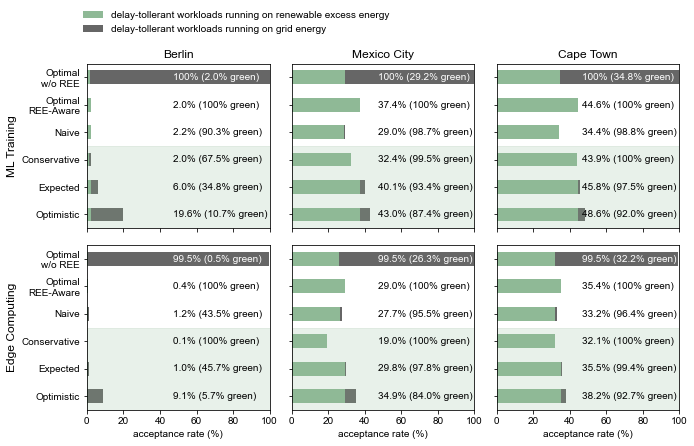

In [11]:
ncols = 3
nbars = 6
f, axs = plt.subplots(ncols=ncols, nrows=2, sharey=True, sharex=True, figsize=(9,5.4))
f.tight_layout(h_pad=0.7, w_pad=0)

pos = 0
for irow, row in enumerate(axs):
    for ax in row:
        countries[pos].plot(kind='barh', stacked=True, ax=ax, legend=False, color=['#8FB996','#666'])  #, color=['#569F61','#664147']
        ax.set_yticklabels([label for label in countries[0]['policy']])
        ax.invert_yaxis()
        ax.set_xlim((0,100))
        ax.set_xlabel("acceptance rate (%)")
        
        acceptance_rates = countries[pos]["green energy used"] + countries[pos]["grid energy used"]
        green_rates = countries[pos]["green energy used"] / acceptance_rates
        
        positions = [p for e, p in enumerate(ax.patches) if e < nbars]
        for position, acceptance_rate, green_rate in zip(positions, acceptance_rates, green_rates):
            acceptance_rate_str = f"{acceptance_rate:.1f}%" if acceptance_rate < 100 else "100%"
            green_rate_str = f"{green_rate:.1%}" if green_rate < 0.999 else "100%"
            annotation = f"{acceptance_rate_str} ({green_rate_str} green)"
            color = 'black' if position.xy[1] > 0 else "white"
            ax.annotate(annotation, (47, position.xy[1]+0.35), color=color, rotation=0)
            
        # ax.axhspan(ymin=-0.5, ymax=1.5, color='black', alpha=0.1)
        ax.axhspan(ymin=2.5, ymax=5.5, color='#8FB996', alpha=0.2)
        
        pos += 1

        
for ax, col in zip(axs[0], ["Berlin", "Mexico City", "Cape Town"]):
    ax.set_title(col)

for ax, row in zip(axs[:,0], ["ML Training", "Edge Computing"]):
    ax.set_ylabel(row, rotation=90, size='large')

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, ["delay-tollerant workloads running on renewable excess energy", "delay-tollerant workloads running on grid energy"], loc='upper left', bbox_to_anchor=(0.032, 1.12), frameon=False, ncol=1)


plt.savefig("figures/evaluation.pdf", dpi=300, bbox_inches='tight')

sns.set_style("ticks")


# Time Plot

In [12]:
def get_jobs_df(scenario, solar_site, policy):
    jobs_df = jobs.copy()
    jobs_df = jobs_df.set_index(['scenario','solar_site','policy','id'])
    jobs_df = jobs_df.loc[scenario, solar_site, policy].copy()
    jobs_df['arrive time'] = pd.to_datetime(jobs_df['arrive time'])
    jobs_df['hour'] = jobs_df['arrive time'].dt.hour
    jobs_df['day'] = jobs_df['arrive time'].dt.day
    return jobs_df

def x(ff):
    ff_grouped = ff.groupby(by=['day','hour'])
    res_list = []
    for k, v in ff_grouped:
        res_list.append([k[1],'job',len(v)])
    df = pd.DataFrame(res_list, columns=['hour', 'type', 'value'])
    for i in range(24):
        if i not in df['hour'].unique():
            res_list.append([i,'job',0])
    df = pd.DataFrame(res_list, columns=['hour', 'type', 'value'])
    return df

def get_power_df(scenario, solar_site):
    power_df = experiment_power_df(scenario=scenario, solar_site=solar_site).reset_index()
    power_df['datetime'] = pd.to_datetime(power_df['datetime'], format='%Y-%m-%d %H:%M:%S')
    power_df['hour'] = power_df['datetime'].dt.hour
    power_df = power_df[['hour','u_reep']]
    power_df.rename(columns={'u_reep':'value'}, inplace=True)
    power_df['type'] = 'energy'
    return power_df

In [13]:
def fancy_boxplots(scenario, solar_site, policy, ax, display_name=None, color_background=False):
    if display_name is None:
        display_name = policy
    ff = get_jobs_df(scenario, solar_site, policy)
    power_df = get_power_df(scenario, solar_site)
    job_df_nr = x(ff[ff['status']!='REJECTED'])
    ax_twinx = ax.twinx()
    #ax_twinx.set_visible(False)
    sns.boxplot(data=job_df_nr, x='hour', y='value', color='gray', ax=ax, fliersize=2)
    sns.lineplot(data=power_df, x='hour', y='value', color='orange', label="excess energy", legend=False, ax=ax_twinx)
    
    if color_background:
        ax.set_facecolor(color='#e8f1e9')
    ax.set_title(display_name)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([0, 4, 8, 12, 16, 20, 24])
    ax.set_xticklabels([0, 4, 8, 12, 16, 20, 24])
    ax_twinx.set_xlabel("")
    ax_twinx.set_ylabel("")
    ax_twinx.set_yticks([])
    return ax_twinx


/var/folders/xy/b5htfw_s12v7jxy5q5n0fcyc0000gn/T/ipykernel_39774/3592591034.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  jobs_df = jobs_df.loc[scenario, solar_site, policy].copy()
/var/folders/xy/b5htfw_s12v7jxy5q5n0fcyc0000gn/T/ipykernel_39774/3592591034.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  jobs_df = jobs_df.loc[scenario, solar_site, policy].copy()
/var/folders/xy/b5htfw_s12v7jxy5q5n0fcyc0000gn/T/ipykernel_39774/3592591034.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  jobs_df = jobs_df.loc[scenario, solar_site, policy].copy()
/var/folders/xy/b5htfw_s12v7jxy5q5n0fcyc0000gn/T/ipykernel_39774/3592591034.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  jobs_df = jobs_df.loc[scenario, solar_site, policy].copy()
/var/folders/xy/b5htfw_s12v7jxy5q5n0fcyc0000gn/T/ipykernel_39774/3592591034.py:4: PerformanceWarning: indexing past lexsort depth may impact

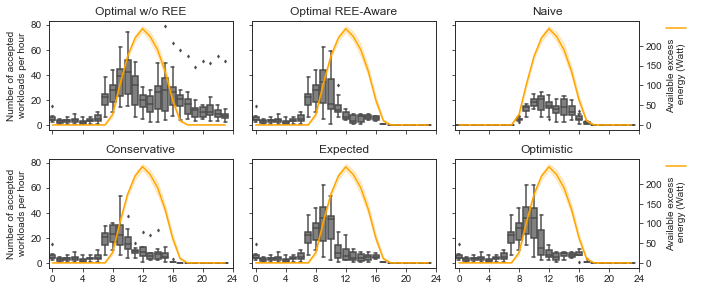

In [14]:
f, axs = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True, figsize=(9,4))
f.tight_layout(h_pad=2, w_pad=0)

fancy_boxplots(scenario='alibaba', solar_site='cdmx', policy="Baseline 1", ax=axs[0][0], display_name="Optimal w/o REE")
fancy_boxplots(scenario='alibaba', solar_site='cdmx', policy="Baseline 2", ax=axs[0][1], display_name="Optimal REE-Aware")
ax_twinx = fancy_boxplots(scenario='alibaba', solar_site='cdmx', policy="Naive", ax=axs[0][2])

ax_twinx.set_yticks([0, 50, 100, 150, 200])
ax_twinx.set_ylabel("Available excess\n energy (Watt)")
handles, labels = ax_twinx.get_legend_handles_labels()
ax_twinx.legend(handles, [""], frameon=False, loc='upper right', bbox_to_anchor=(1.35, 1.05))

fancy_boxplots(scenario='alibaba', solar_site='cdmx', policy="Conservative", ax=axs[1][0])
fancy_boxplots(scenario='alibaba', solar_site='cdmx', policy="Expected", ax=axs[1][1])
ax_twinx = fancy_boxplots(scenario='alibaba', solar_site='cdmx', policy="Optimistic", ax=axs[1][2])

ax_twinx.set_yticks([0, 50, 100, 150, 200])
ax_twinx.set_ylabel("Available excess\n energy (Watt)")
handles, labels = ax_twinx.get_legend_handles_labels()
ax_twinx.legend(handles, [""], frameon=False, loc='upper right', bbox_to_anchor=(1.35, 1.05))

axs[0][0].set_ylabel("Number of accepted\nworkloads per hour")
axs[1][0].set_ylabel("Number of accepted\nworkloads per hour")

plt.savefig("figures/boxplots.pdf", dpi=300, bbox_inches='tight')
